In [119]:
#this code with the modified sampeling period case 4 considering time delay at output
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pickle
import csv
from mpl_toolkits import mplot3d



### Define Model

In [120]:
import glob
import ctypes
import math
### Setup the environment

num_states=31# 18states, 3dt, 4p'_r'_p''_r'', 12pr_inputs

num_actions=3 # u_x, u_y, u_z

mass=0.67 #in kg

prev_input_number = 15

g=9.81

upper_bound_x= 6 # i.e. coefficient of thrust to weight=2
upper_bound_y= 6 # i.e. coefficient of thrust to weight=2
upper_bound_z= 6 # i.e. coefficient of thrust to weight=2

lower_bound_x= -6 # we cannot do better without upside-down
lower_bound_y=-6
lower_bound_z= -6
vel_reward_weight_factor=0

libfile = glob.glob('../Sim_intfc/out/build/linux-default/libinterface_simulink.so.1')[0]
mylib = ctypes.CDLL(libfile)

class EnvUAV_cmd_z:
    simulink_input_length=3

    simulink_states_length=37
    print_period=7 #in seconds
    episode_timeout= 5 #in seconds
    termination_causes={'passed behind window plane':0,'time_out':1,'nan_error':2}
    def __init__(self,simulation_dt,sampling_dt,mass=2.25,CTW=1.88,g=9.81):
        mylib.LoadModel()
        mylib.run_a_step.restype = np.ctypeslib.ndpointer(dtype=np.float64,shape=(self.simulink_states_length,))
        mylib.run_a_step.argtypes = [np.ctypeslib.ndpointer(dtype=np.float64),ctypes.c_int]

        self.simulation_dt=simulation_dt
        self.sampling_dt=sampling_dt
        self.sim_steps_per_samp_period=round(self.sampling_dt/self.simulation_dt) # Note sim dt must not be larger than sampling dt

        self.steps_per_print_period=int(EnvUAV_cmd_z.print_period/self.sampling_dt)
        self.sampling_step_counter=0
        self.reset()
    
    def __call__(self,input):
        self.sampling_step_counter=self.sampling_step_counter+1
        inputs = np.zeros(EnvUAV_cmd_z.simulink_input_length,dtype=np.float64)
        inputs[:3] = np.copy(input[:3])
        
        for i in range(self.sim_steps_per_samp_period): # Simulink solver is run at a higher rate for numerical stability
            self.states_meas = mylib.run_a_step(inputs,len(inputs))

        self.all_states_meas[0] = np.copy(self.states_meas[0])
        for i in range(1,9): #errors
            self.all_states_meas[i] = np.copy(self.states_meas[i])
        self.all_states_meas[2] -= 1    
          
        indices_to_copy = [25, 26, 27, 16, 17, 19, 20]
        for i, index in enumerate(indices_to_copy, start=9):# dt,omegas,omegas'
            self.all_states_meas[i] = np.copy(self.states_meas[index])

        if num_states==31: # d =10 for each input (30)
            self.all_states_meas[16:19] = np.copy(input[:3])
            self.all_states_meas[19:31] = np.copy(self.prevv_input)
            self.prevv_input[3:12] = self.prevv_input[:9]
            self.prevv_input[:3] = np.copy(input[:3])

        #norm_val = np.linalg.norm(self.all_states_meas)
        #self.all_states_meas = self.all_states_meas/norm_val
        #cost function
        elements = np.array([
            self.all_states_meas[0],
            self.all_states_meas[1] ,
            self.all_states_meas[2],
            vel_reward_weight_factor * self.all_states_meas[3],
            vel_reward_weight_factor * self.all_states_meas[4],
            vel_reward_weight_factor * self.all_states_meas[5]
        ])
        cost = np.linalg.norm(elements)       
        self.reward=-cost*self.sampling_dt*100 # By 100 to 25 up reward for training
        
        #if en_goal_termination==True:    
            #if (self.states_meas[0] - self.states_meas [28] < 0):
                #self.termination_cause=EnvUAV_cmd_z.termination_causes['passed behind window plane']
                #print('Passed window plane!')
                #self.done=True
            
        if (self.sampling_step_counter*self.sampling_dt>EnvUAV_cmd_z.episode_timeout):
            self.termination_cause=EnvUAV_cmd_z.termination_causes['time_out']
            self.done=True
        
        if any(math.isnan(self.all_states_meas[i]) for i in range(6)):            
            self.all_states_meas=np.zeros(num_states)
            self.reward=np.ones(1)*0.0
            self.termination_cause=EnvUAV_cmd_z.termination_causes['nan_error']
            print('Warning NaN termination')
            self.done=True
        return self.all_states_meas, self.reward, self.done, self.termination_cause, self.states_meas[28:31], self.states_meas[0:3], self.states_meas[13:16]

    def reset(self):
        if self.sampling_step_counter>0:
            mylib.TermModel()
        self.sampling_step_counter=0
        mylib.LoadModel()
        mylib.InitModel()
        self.done=False
        self.all_states_meas=np.zeros(num_states)
        self.prevv_input=np.zeros(prev_input_number-3)
        self.termination_cause=EnvUAV_cmd_z.termination_causes['passed behind window plane']
        return self.all_states_meas

    def print_states_periodic(self):
        if self.sampling_step_counter % self.steps_per_print_period ==1: #here
            print('simulation time (s): ' + str(self.sampling_step_counter*self.sampling_dt))
            print('===================')

simulink_dt=0.001 # Simulink solver step time
sampling_dt=0.01# The one that would be used experimentally. e.g. corresponds to 200Hz

UAV_alt_ctrl=EnvUAV_cmd_z(simulink_dt,sampling_dt)




** starting the model **

** starting the model **


In [121]:
print(UAV_alt_ctrl.sim_steps_per_samp_period)

10


In [122]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [123]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1)) 
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        # self.action_buffer[index] = np.array(obs_tuple[1]).flatten()
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

### Define Actor-Critic

In [124]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.2, maxval=0.2) #MC
    multiple_factor=2
    inputs = layers.Input(shape=(num_states,))
    inputs = layers.Normalization(axis=-1) (inputs)
    out = layers.Dense(multiple_factor*256, activation="relu")(inputs)
    out = layers.Dense(multiple_factor*256, activation="relu")(out)
    outputs = layers.Dense(3, activation="tanh", kernel_initializer=last_init)(out)


    # Scale each output separately
    outputs = outputs * tf.constant([upper_bound_x, upper_bound_y, upper_bound_z], dtype=tf.float32)

    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    multiple_factor=2
    state_input = layers.Input(shape=(num_states))

    state_out = layers.Dense(multiple_factor*16, activation="relu")(state_input)
    state_out = layers.Dense(multiple_factor*32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(multiple_factor*32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(multiple_factor*256, activation="relu")(concat)
    out = layers.Dense(multiple_factor*256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [125]:
lower_bounds = [lower_bound_x, lower_bound_y, lower_bound_z]
upper_bounds = [upper_bound_x, upper_bound_y, upper_bound_z]
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise # WARNING NOISE MIGHT BE DISABLED

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bounds, upper_bounds)

    return [np.squeeze(legal_action)] 


### Hyperparameters

In [126]:
# RL models
actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1500
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(400000, 2048)

# nosie model
init_std_dev = 0.4
final_exponent_val=10 #formula std_dev=init_std_dev * exp^(-(ep/total_episodes)*final_exponent_val)
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(init_std_dev) * np.ones(1))
en_noise_decay=False

# model behaviour
en_goal_termination=True


### Train

In [127]:
# To store reward history of each episode
ep_reward_list = []

# To store average reward history of last few episodes
avg_reward_list = []

# To store final states of the system
final_states_reward_list = []  # [states, reward]

# To store termiantion status
termination_causes_list=[]

# To store all state_action pairs
states_action_list=[]
states_action_lists=[]
window_state_list=[]
window_state_lists=[]
drone_state_list=[]
drone_state_lists=[]
actor_model_list = []
drone_orientation_list = []
drone_orientation_lists = []

learning_frequency=256 #MC

for ep in range(total_episodes):

    #prev_state = env.reset()
    prev_state = UAV_alt_ctrl.reset()
    episodic_reward = 0 # Total rewards in one episode

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0) # Necessary for tensorflow (check immutable/mutable data types if you want to know more)

        action = policy(tf_prev_state, ou_noise)
        action = list(action[0]) 
        # Recieve state and reward from environment.
        #state, reward, done, info = env.step(action)
        state, reward, done, termination_cause, window_position, drone_position, drone_orientation =UAV_alt_ctrl(action)
        states_action_list.append([state.copy(),action.copy()])
        window_state_list.append(window_position.copy())
        drone_state_list.append(drone_position.copy())
        drone_orientation_list.append(drone_orientation.copy())

        buffer.record((prev_state.copy(), action.copy(), reward.copy(), state.copy()))
        episodic_reward += reward

        if buffer.buffer_counter>buffer.batch_size:
            if (buffer.buffer_counter%(int(buffer.batch_size/learning_frequency))==1):
                buffer.learn()
                update_target(target_actor.variables, actor_model.variables, tau)
                update_target(target_critic.variables, critic_model.variables, tau)


        # End this episode when `done` is True
        if done:
            break

        prev_state = np.copy(state)

    current_actor_model = tf.keras.models.clone_model(actor_model)
    current_actor_model.set_weights(actor_model.get_weights())
    actor_model_list.append(current_actor_model)
    ep_reward_list.append(episodic_reward)
    termination_causes_list.append(termination_cause)
    final_states_reward_list.append([state.copy(),reward.copy()])
    states_action_lists.append(states_action_list.copy())
    window_state_lists.append(window_state_list.copy())
    drone_state_lists.append(drone_state_list.copy())
    drone_orientation_lists.append(drone_orientation_list.copy())
    states_action_list.clear()
    window_state_list.clear()
    drone_state_list.clear()
    drone_orientation_list.clear()

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    print("Episode * {} * Reward is ==> {}".format(ep, episodic_reward))
        
    avg_reward_list.append(avg_reward)
    if en_noise_decay:
        ou_noise.std_dev[0]=init_std_dev * math.exp(-(ep/total_episodes)*final_exponent_val)





** starting the model **
Episode * 0 * Avg Reward is ==> -4565.804117016562
Episode * 0 * Reward is ==> -4565.804117016562

** starting the model **
Episode * 1 * Avg Reward is ==> -4480.772254797994
Episode * 1 * Reward is ==> -4395.740392579426

** starting the model **
Episode * 2 * Avg Reward is ==> -4674.869405621469
Episode * 2 * Reward is ==> -5063.06370726842

** starting the model **
Episode * 3 * Avg Reward is ==> -5272.606229137318
Episode * 3 * Reward is ==> -7065.816699684866

** starting the model **
Episode * 4 * Avg Reward is ==> -5454.898758803338
Episode * 4 * Reward is ==> -6184.068877467415

** starting the model **
Episode * 5 * Avg Reward is ==> -5628.429106711826
Episode * 5 * Reward is ==> -6496.080846254269

** starting the model **
Episode * 6 * Avg Reward is ==> -6589.320541186035
Episode * 6 * Reward is ==> -12354.669148031295

** starting the model **
Episode * 7 * Avg Reward is ==> -6945.1913851668405
Episode * 7 * Reward is ==> -9436.287293032474

** sta

### Plotting

In [ ]:
print(termination_causes_list)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

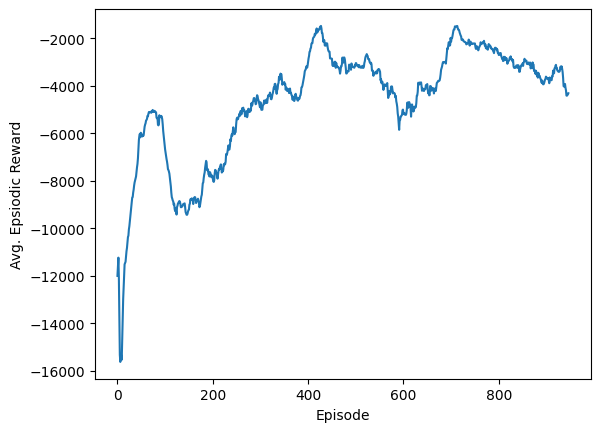

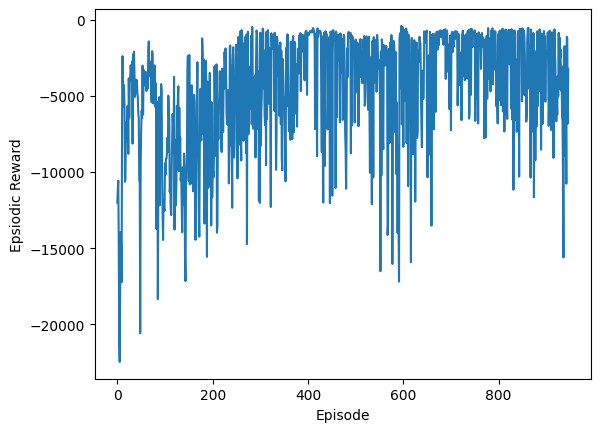

In [ ]:
# Plotting graph
# Episodes versus Avg. Rewards
num_of_episodes=len(avg_reward_list)
t=np.arange(num_of_episodes)+(len(avg_reward_list)-num_of_episodes)
plt.plot(t,avg_reward_list[-num_of_episodes:])
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")

plt.show()
plt.plot(t,ep_reward_list[-num_of_episodes:])
plt.xlabel("Episode")
plt.ylabel("Epsiodic Reward")
plt.show()


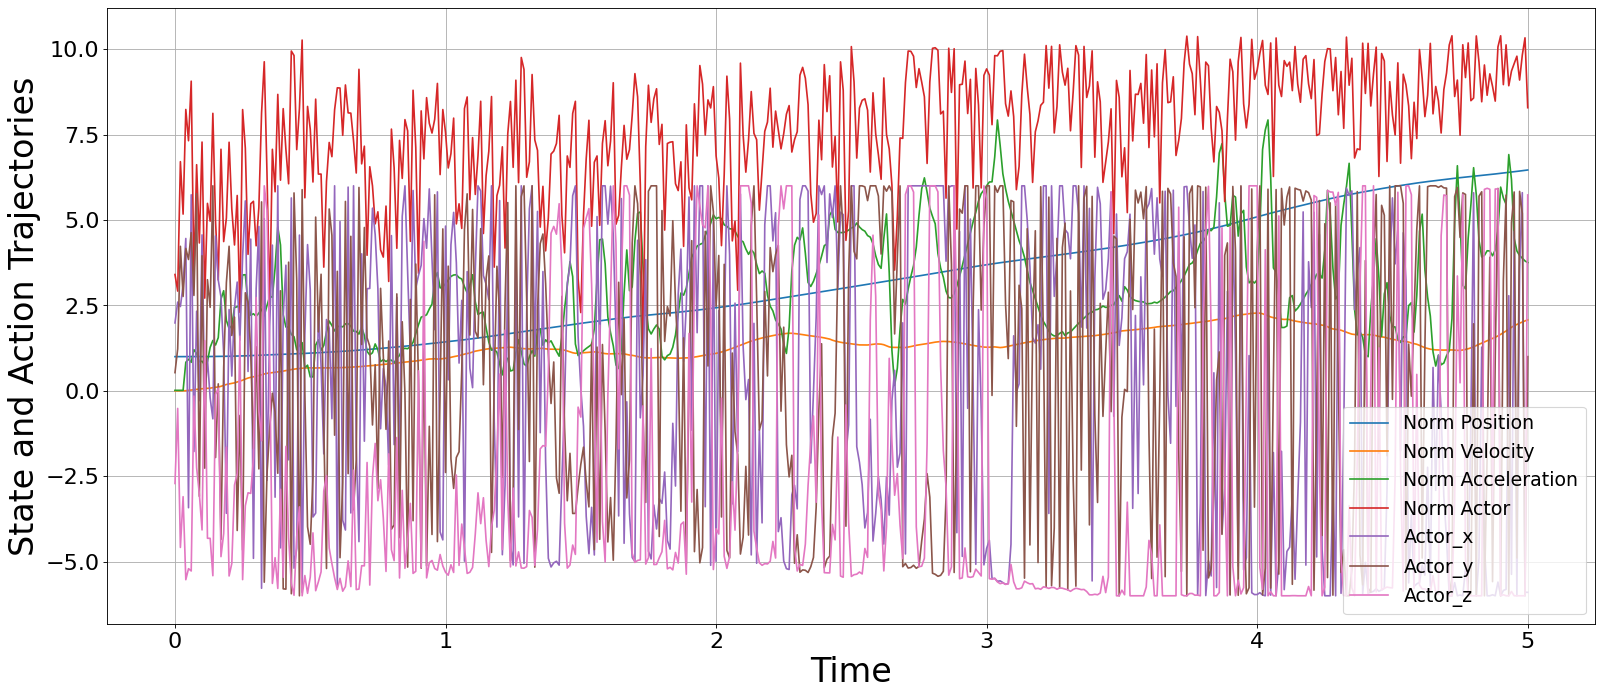

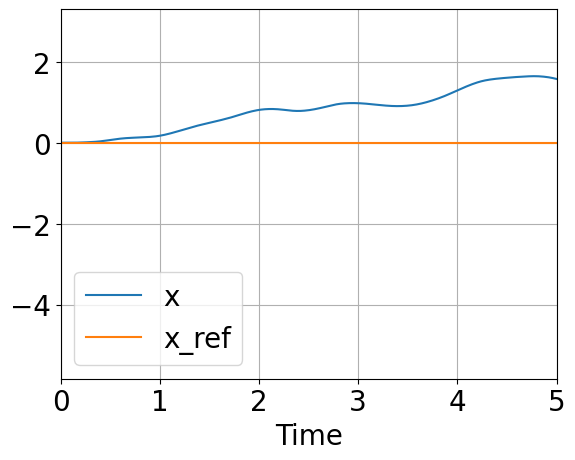

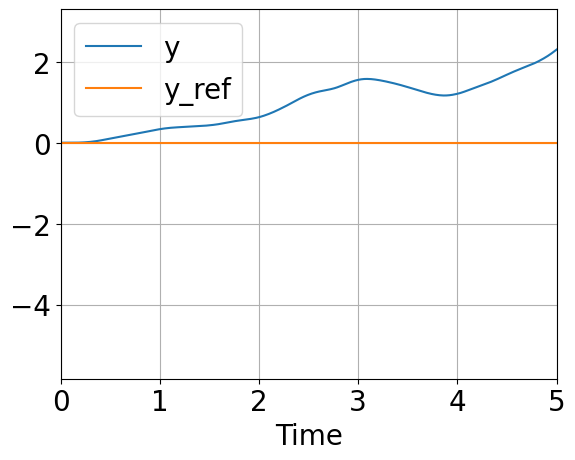

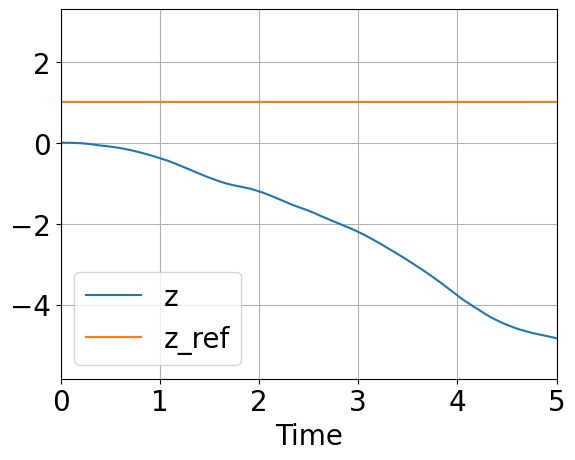

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from matplotlib.animation import FuncAnimation

# Plotting states
index_of_episode = 57
pos_diff_norm = []
vel_diff_norm = []
acc_diff_norm = []
states_list_train = []
actions_list_train = []
act_norm = []
act_vals_x, act_vals_y, act_vals_z = [], [], []
inst_reward, accum_reward = [], []
time_vals = np.linspace(0, EnvUAV_cmd_z.episode_timeout, len(states_action_lists[index_of_episode]))
window_vals = window_state_lists[index_of_episode]
drone_vals = drone_state_lists[index_of_episode]
drone_orient = drone_orientation_lists[index_of_episode]
drone_x = [item[0] for item in drone_vals]
drone_y = [item[1] for item in drone_vals]
drone_z = [item[2] for item in drone_vals]
drone_orient_x = [item[0] for item in drone_orient]
drone_orient_y = [item[1] for item in drone_orient]
drone_orient_z = [item[2] for item in drone_orient]
window_x = [item[0] for item in window_vals]
window_y = [item[1] for item in window_vals]
window_z = [item[2] for item in window_vals]
for tuble in states_action_lists[index_of_episode]:
    pos_val_x, pos_val_y, pos_val_z = tuble[0][:3]
    pos_diff_norm.append(np.linalg.norm([pos_val_x, pos_val_y, pos_val_z]))
    
    vel_val_x, vel_val_y, vel_val_z = tuble[0][3:6]
    vel_diff_norm.append(np.linalg.norm([vel_val_x, vel_val_y, vel_val_z]))
    #print(tuble[0][14])
    acc_val_x, acc_val_y, acc_val_z = tuble[0][6:9]
    acc_diff_norm.append(np.linalg.norm([acc_val_x, acc_val_y, acc_val_z]))
    
    e1, e2, e3, e4, e5, e6 = tuble[0][:6]
    e7, e8, e9, e10, e11, e12 = tuble[0][9:15]
    e1w, e2w, e3w = tuble[0][15:18]
    e13, e14, e15, e16, e17 = tuble[0][18:23]
    e18,e19,e20 = tuble[0][25:28]

    states_list_train.append([e1, e2, e3, e4, e5, e6,0,0,0,e7, e8, e9, e10, e11, e12,e1w, e2w, e3w, e13, e14, e15, e16, e17,0,0,e18,e19,e20])
    act_vals = tuble[1]
    act_x = act_vals[0]
    act_y = act_vals[1]
    act_z = act_vals[2]
    act_vals_x.append(act_vals[0])
    act_vals_y.append(act_vals[1])
    act_vals_z.append(act_vals[2])
    act_norm.append(np.linalg.norm([act_x, act_y, act_z]))
    actions_list_train.append([act_x, act_y, act_z])
    inst_reward.append(-(pos_diff_norm[-1] + (vel_reward_weight_factor ** 2) * vel_diff_norm[-1]) * UAV_alt_ctrl.sampling_dt * 100 * 0.1)
    accum_reward.append(sum(inst_reward))


drone_xm = np.array(drone_x)
drone_ym = np.array(drone_y)
drone_zm = np.array(drone_z)

# Now you can perform element-wise squaring and summing
pos_diff_norm = np.sqrt((drone_xm**2 + drone_ym**2 + (drone_zm-1)**2))

plt.close()
figure(figsize=(24, 10), dpi=80)
#print(state)
plt.plot(time_vals,pos_diff_norm)
plt.plot(time_vals,vel_diff_norm)
plt.plot(time_vals,acc_diff_norm)
plt.plot(time_vals,act_norm)
#plt.plot(time_vals,act_vals_z)
plt.plot(time_vals,act_vals_x)
plt.plot(time_vals,act_vals_y)
plt.plot(time_vals,act_vals_z)
#plt.plot(time_vals,accum_reward)
#plt.plot(time_vals,inst_reward)


plt.xlabel("Time",fontsize = '30')
plt.ylabel("State and Action Trajectories",fontsize = '30')
plt.rcParams.update({'font.size': 20})

plt.legend(['Norm Position','Norm Velocity','Norm Acceleration','Norm Actor','Actor_x','Actor_y','Actor_z','accumelated reward (x0.1)','Instantaneous reward'],loc='lower right', fontsize=17)
plt.grid()
plt.show()


# Create a figure and axis for the plot
fig, ax = plt.subplots()
plt.plot(time_vals,drone_x)
plt.plot(time_vals,np.zeros(len(drone_x)))
ax.set_xlim(0, max(max(time_vals), max(time_vals)))
ax.set_ylim(min(min(drone_y), min(drone_z)) - 1, max(max(drone_y), max(drone_z)) + 1)
plt.xlabel('Time')
#plt.ylabel('y')
#plt.title('Drone Altitude and Window Altitude vs. Time')
plt.legend(['x','x_ref'])
plt.grid()
plt.show()
plt.close()
fig, ax = plt.subplots()
plt.plot(time_vals,drone_y)
plt.plot(time_vals,np.zeros(len(drone_y)))
ax.set_xlim(0, max(max(time_vals), max(time_vals)))
ax.set_ylim(min(min(drone_y), min(drone_z)) - 1, max(max(drone_y), max(drone_z)) + 1)
plt.xlabel('Time')
plt.legend(['y','y_ref'])
plt.grid()
plt.show()
plt.close()
fig, ax = plt.subplots()
plt.plot(time_vals,drone_z)
plt.plot(time_vals,np.ones(len(drone_z)))
ax.set_xlim(0, max(max(time_vals), max(time_vals)))
ax.set_ylim(min(min(drone_y), min(drone_z)) - 1, max(max(drone_y), max(drone_z)) + 1)
plt.xlabel('Time')
plt.legend(['z','z_ref'])
plt.grid()
plt.show()
plt.close()



In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def euler_to_rotation_matrix(roll, pitch, yaw):
    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])

    R_y = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])

    R_z = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])

    # Assuming the order of rotations is roll, pitch, then yaw (XYZ convention)
    R = np.dot(R_z, np.dot(R_y, R_x))
    return R

def rotate(points, theta):
    rotation_matrix = np.array([
        [np.cos(-theta), -np.sin(-theta)],
        [np.sin(-theta),  np.cos(-theta)]
    ])
    return np.dot(points, rotation_matrix)

s = 0.75  # Side length
half_s = s / 2

# Square corners before rotation
corners = np.array([
    [-half_s+half_s/2, -half_s],
    [half_s-half_s/2, -half_s],
    [half_s-half_s/2, half_s],
    [-half_s+half_s/2, half_s]
])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.close()
def update(num,x, y,z,x2,y2,z2,roll,pitch,yaw):
    ax.clear()
    r = np.sqrt(y2[num]**2 + z2[num]**2)  # radius
    theta = np.arctan2(z2[num], y2[num])
    R = euler_to_rotation_matrix(roll[num], pitch[num], yaw[num])
    y_center = r * np.cos(theta)
    z_center = r * np.sin(theta)
    body_axes = np.array([[2.5, 0, 0],
                      [0, 2.5, 0],
                      [0, 0, 1]])
    rotated_corners = rotate(corners, theta)
    rotated_corners[:, 0] = rotated_corners[:, 0] + y_center
    rotated_corners[:, 1] = rotated_corners[:, 1] + z_center
    rotated_axes = np.dot(R, body_axes)
    ax.quiver(x[num], y[num], z[num], rotated_axes[0, 0], rotated_axes[1, 0], rotated_axes[2, 0], color='r', length=0.1)
    ax.quiver(x[num], y[num], z[num], rotated_axes[0, 1], rotated_axes[1, 1], rotated_axes[2, 1], color='g', length=0.1)
    ax.quiver(x[num], y[num], z[num], rotated_axes[0, 2], rotated_axes[1, 2], rotated_axes[2, 2], color='b', length=0.1)

    scatter = ax.scatter(x2[num], y2[num], z2[num], c='red', cmap='viridis')
    scatter2 = ax.scatter(x[num], y[num], z[num], c='green', cmap='plasma')
    ax.plot(x2[:num], y2[:num], z2[:num], color='red', linewidth=2)
    ax.plot(x[:num], y[:num], z[:num], color='green', linewidth=2)
    x = -1.5  # The x-coordinate for all points

    vertices = [(x, y, z) for y, z in rotated_corners]
    rect = Poly3DCollection([vertices], alpha=0.5, linewidths=1, edgecolors='r')
    ax.add_collection3d(rect)

    ax.legend(['Window', 'drone'], loc='upper left',fontsize='9')
    ax.set_xlabel('X-axis', fontsize='9')
    ax.set_ylabel('Y-axis', fontsize='9')
    ax.set_zlabel('Z-axis', fontsize='9')
    ax.set_xlim(-2.5,0)
    ax.set_ylim(-1.5,1.5)
    ax.set_zlim(0.4,1.2)
    ax.tick_params(axis='x', labelsize='9')
    ax.tick_params(axis='y', labelsize='9')
    ax.tick_params(axis='z', labelsize='9')
ani = FuncAnimation(fig, update, frames=range(0, len(drone_x), 1),fargs=[drone_x, drone_y, drone_z, window_x, window_y, window_z,drone_orient_x, drone_orient_y,drone_orient_z], interval=50)
from IPython.display import HTML

HTML(ani.to_html5_video())


/tmp/ipykernel_85037/1111373731.py:65: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x2[num], y2[num], z2[num], c='red', cmap='viridis')
/tmp/ipykernel_85037/1111373731.py:66: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter2 = ax.scatter(x[num], y[num], z[num], c='green', cmap='plasma')


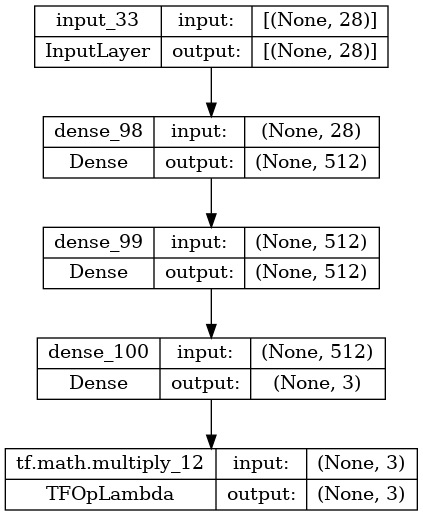

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Example state-action tuples
# States are (x, y) positions, actions are one-hot encoded.
states = np.array(states_list_train, dtype=np.float32)
actions = np.array(actions_list_train, dtype=np.float32)

# Convert NumPy arrays to TensorFlow Tensors
states = tf.convert_to_tensor(states, dtype=tf.float32)
actions = tf.convert_to_tensor(actions, dtype=tf.float32)
actor_model = tf.keras.models.clone_model(actor_model_list[index_of_episode])
actor_model.set_weights(actor_model_list[index_of_episode].get_weights())
from keras.utils.vis_utils import plot_model 
plot_model(actor_model, to_file='layers_plot.png', show_shapes=True, show_layer_names=True)


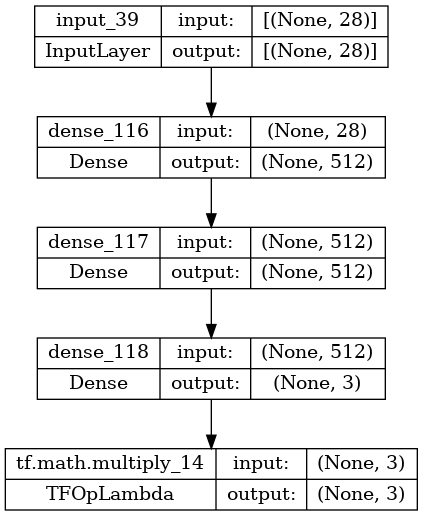

In [ ]:
# Build a simple imitation learning model
# student_model = keras.Sequential([
#     keras.layers.Input(shape=(47,)),
#     keras.layers.Dense(2*256, activation='relu'),
#     keras.layers.Dense(2*256, activation='relu'),
#     keras.layers.Dense(3, activation='tanh')  # Output shape represents the actions
# ])
# def get_student(teacher_model):
#     multiple_factor=2
#     inputs = layers.Input(shape=(47,))
#     out = layers.Dense(multiple_factor*256, activation="relu")(inputs)
#     out = layers.Dense(multiple_factor*256, activation="relu")(out)
#     outputs = layers.Dense(3, activation="tanh")(out)

#     outputs = outputs * upper_bound
#     model = tf.keras.Model(inputs, outputs)
#     return model
student_model = get_actor()
student_model.set_weights(actor_model.get_weights())
student_model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['acc'])
plot_model(student_model, to_file='layers_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:

train_size = int(0.7 * len(states))

# Create a random permutation of indices
indices = tf.random.shuffle(tf.range(len(states)))
# Gather the data for the training set
states_inter = tf.gather(states, indices[:train_size])
actions_inter = tf.gather(actions, indices[:train_size])
train_size_new = int(0.7 * len(states_inter))
indices_new = tf.random.shuffle(tf.range(len(states_inter)))
states_train = tf.gather(states_inter, indices_new[:train_size_new])
actions_train = tf.gather(actions_inter, indices_new[:train_size_new])
states_validate = tf.gather(states_inter, indices_new[train_size_new:])
actions_validate = tf.gather(actions_inter, indices_new[train_size_new:])
states_test = tf.gather(states, indices[train_size:])
actions_test = tf.gather(actions, indices[train_size:])
history = student_model.fit(states_train, actions_train, epochs=1000, batch_size=15,verbose=0,validation_data=(states_validate, actions_validate))


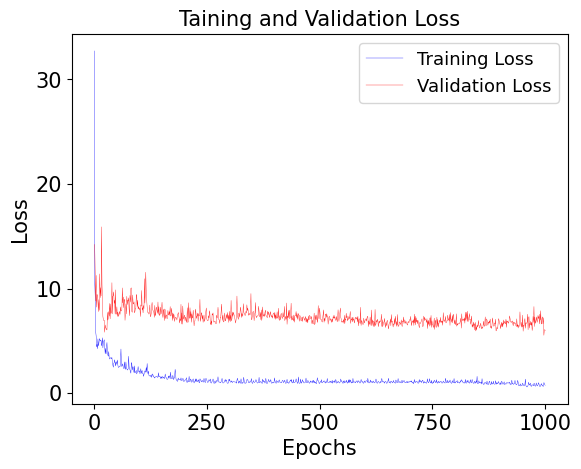

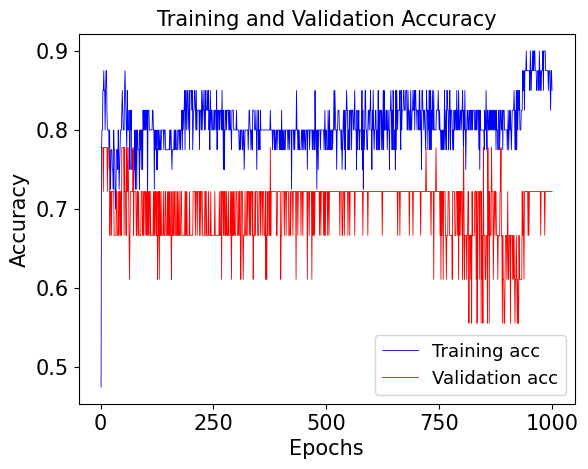

In [ ]:
history_dict = history.history
history_dict.keys()
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1,len(loss_values)+1)
plt.plot(epochs,loss_values,'b',linewidth=0.25,label='Training Loss')
plt.plot(epochs,val_loss_values,'r',linewidth=0.25,label='Validation Loss')
plt.title('Taining and Validation Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(loc='upper right', fontsize=13)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xlim(0,750)
plt.show()
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs,acc_values,'b',linewidth=0.6,label='Training acc')
plt.plot(epochs,val_acc_values,'r',linewidth=0.6,label='Validation acc')
plt.title('Training and Validation Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right', fontsize=13)
plt.show()



In [ ]:

new_student_model = get_actor()
new_student_model.set_weights(actor_model.get_weights())
new_student_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])
history_new = new_student_model.fit(states_inter, actions_inter, epochs=315, batch_size=15,verbose=0)
_, accuracy = new_student_model.evaluate(states_test, actions_test)
_, accuracy_all = new_student_model.evaluate(states, actions)
print('Accuracy for Testing data: %.2f' % (accuracy*100))
print('Accuracy for All data: %.2f' % (accuracy_all*100))


3/3 [==============================] - 0s 4ms/step - loss: 3.1913 - acc: 0.8690
Accuracy for Testing data: 84.62
Accuracy for All data: 86.90


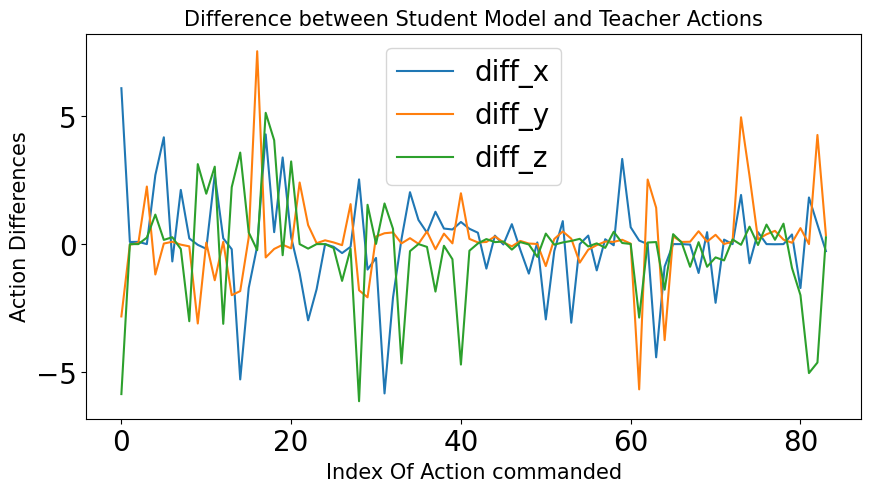

In [ ]:


# # Create a list to store the differences
action_differences = []

# Loop through states, predict actions, and calculate differences
for i, state in enumerate(states):
    # Predict action using the imitation model
    reshaped = tf.expand_dims(tf.convert_to_tensor(state), 0)
    predicted_action = new_student_model.predict(reshaped, verbose=0)

    # Assuming you have the actor's action available as a list with three values
    actor_action = actions[i]

    # Calculate the absolute difference between predicted action and actor's action
    action_difference = (np.array(predicted_action) - np.array(actor_action))

    # Append the difference to the list
    action_differences.append(action_difference)

# Convert the list of differences to a NumPy array
action_differences = np.array(action_differences)
diff_x = action_differences[:, :, 0] 
diff_y = action_differences[:, :, 1] 
diff_z = action_differences[:, :, 2] 
x_axiss = np.arange(diff_x.size)
# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(x_axiss, diff_x, label="diff_x")
plt.plot(x_axiss, diff_y, label="diff_y")
plt.plot(x_axiss, diff_z, label="diff_z")
plt.xlabel("Index Of Action commanded",fontsize=15)
plt.ylabel("Action Differences",fontsize=15)
plt.title("Difference between Student Model and Teacher Actions",fontsize=15)
plt.legend()
plt.show()

In [ ]:
window_state_list_st = []
drone_state_list_st = []
drone_orientation_list_st = []
UAV_alt_ctrl_student=EnvUAV_cmd_z(simulink_dt,sampling_dt)
UAV_alt_ctrl_student.reset()
state_st, reward_st, done_st, termination_cause_st, window_position_st, drone_position_st,drone_orientation_st = UAV_alt_ctrl_student(actions[0])

for i in range(len(drone_x)):
    state_st[6:9] = state_st[23:25] = 0
    reshaped_st = tf.expand_dims(tf.convert_to_tensor(state_st), 0)
    predicted_action_st = new_student_model.predict(reshaped_st, verbose=0)
    # Update state with the predicted action
    state_st, reward_st, done_st, termination_cause_st, window_position_st, drone_position_st,drone_orientation_st = UAV_alt_ctrl_student(predicted_action_st)
    window_state_list_st.append(window_position_st.copy())
    drone_state_list_st.append(drone_position_st.copy())
    drone_orientation_list_st.append(drone_orientation_st.copy())
    
fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
plt.close()
drone_xst = [item[0] for item in drone_state_list_st]
drone_yst = [item[1] for item in drone_state_list_st]
drone_zst = [item[2] for item in drone_state_list_st]
drone_orient_xst = [item[0] for item in drone_orientation_list_st]
drone_orient_yst = [item[1] for item in drone_orientation_list_st]
drone_orient_zst = [item[2] for item in drone_orientation_list_st]
window_xst = [item[0] for item in window_state_list_st]
window_yst = [item[1] for item in window_state_list_st]
window_zst = [item[2] for item in window_state_list_st]
ani2 = FuncAnimation(fig2, update, frames=range(0, len(drone_x), 1),fargs=[drone_xst, drone_yst, drone_zst, window_xst, window_yst, window_zst,drone_orient_xst,drone_orient_yst,drone_orient_zst], interval=50)
from IPython.display import HTML

HTML(ani2.to_html5_video())


** starting the model **

** starting the model **

** starting the model **


/tmp/ipykernel_85037/1111373731.py:65: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x2[num], y2[num], z2[num], c='red', cmap='viridis')
/tmp/ipykernel_85037/1111373731.py:66: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter2 = ax.scatter(x[num], y[num], z[num], c='green', cmap='plasma')


In [ ]:
print(tf.size(states))

tf.Tensor(2352, shape=(), dtype=int32)


In [ ]:


# Specify the CSV file name
csv_file = 'time_data.csv'

# Open the CSV file in write mode
with open(csv_file, 'w') as file:
    # Write the vector data to the file
    for value in time_vals:
        file.write(str(value) + '\n')

print(f"Vector data saved to {csv_file} successfully.")



Vector data saved to time_data.csv successfully.


In [ ]:
# Specify the CSV file name
csv_file = 'pos_data.csv'

# Open the CSV file in write mode
with open(csv_file, 'w') as file:
    # Write the vector data to the file
    for value in pos_vals:
        file.write(str(value) + '\n')

print(f"Vector data saved to {csv_file} successfully.")


NameError: name 'pos_vals' is not defined

In [ ]:
# Specify the CSV file name
csv_file = 'actor_data.csv'

# Open the CSV file in write mode
with open(csv_file, 'w') as file:
    # Write the vector data to the file
    for value in act_vals:
        file.write(str(value) + '\n')

print(f"Vector data saved to {csv_file} successfully.")


In [ ]:
# Plotting of value function
%matplotlib widget
from random import sample
from tabnanny import verbose
from mpl_toolkits.mplot3d import Axes3D

import pickle
import csv

## Inquiry actor
# Mesh initiation
samples_per_dim=20

pos_range=[-100,100]
vel_range=[-100,100]
acc_range=[-5,5]

pos_states=np.linspace(pos_range[0],pos_range[1],samples_per_dim)

vel_states=np.linspace(vel_range[0],vel_range[1],samples_per_dim)

acc_states=np.linspace(acc_range[0],acc_range[1],samples_per_dim)

value_function=np.linspace((pos_range[0],vel_range[0]),(pos_range[1],vel_range[1]),samples_per_dim)

actor_output=np.zeros([samples_per_dim,samples_per_dim,samples_per_dim])

value_function=np.ones([samples_per_dim,samples_per_dim,samples_per_dim])

default_acc_state=acc_states[-1]

for i in range(samples_per_dim):
    for j in range(samples_per_dim):
        #for k in range(samples_per_dim):
        input_to_actor=np.asarray([pos_states[i],vel_states[j],default_acc_state])
        input_to_actor=input_to_actor.reshape(1,3)
        actor_output[i,j,0]=actor_model.predict(input_to_actor,verbose=0)


for i in range(samples_per_dim):
    for j in range(samples_per_dim):
        #for k in range(samples_per_dim):
        input_to_critic_states=np.asarray([pos_states[i],vel_states[j],default_acc_state])
        input_to_critic_states=input_to_critic_states.reshape(1,3)  #norhan
        input_to_critic_action=np.asarray([actor_output[i,j,0]])
        value_function[i,j,0]=critic_model([input_to_critic_states,input_to_critic_action])
            




In [ ]:
# creating figure
fig = plt.figure()
ax = Axes3D(fig)
  
with open('value_function.csv','w') as f:
    write = csv.writer(f)
    for i in range(samples_per_dim):
        for j in range(samples_per_dim):
            ax.scatter(pos_states[i], vel_states[j], value_function[i,j,0], color='green')
            #write_list=[pos_states[i],vel_states[j],value_function[i,j,0]]
            #write.writerows(write_list)


  
# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('Value Function')
  
# displaying the plot
plt.show()

In [ ]:
# Plotting actor output

forced_acc_state=0.0
num_pts=30

actor_output=np.zeros(num_pts)

# 1 fix velocity and vary position
forced_velocity=0.0
pos_max=10

ranged_position=np.linspace(-pos_max,pos_max,num_pts)

for i in range(num_pts):
    input_to_actor=np.asarray([ranged_position[i],forced_velocity,forced_acc_state])
    input_to_actor=input_to_actor.reshape(1,3)
    actor_output[i]=actor_model.predict(input_to_actor,verbose=0)

plt.close()
fig=plt.figure(figsize=(24, 10), dpi=80)
axes=fig.add_subplot(1,1,1)
axes.set_xticks(np.arange(-pos_max,pos_max,1))
plt.plot(ranged_position,actor_output)
plt.xlabel("position")
plt.ylabel("action")


plt.grid()
plt.show()


In [ ]:
# Plotting actor output

# 2 fix position and vary velocity
forced_position=0.0
vel_max=10
ranged_vel=np.linspace(-vel_max,vel_max,num_pts)

for i in range(num_pts):
    input_to_actor=np.asarray([forced_position,ranged_vel[i],forced_acc_state])
    input_to_actor=input_to_actor.reshape(1,3)
    actor_output[i]=actor_model.predict(input_to_actor,verbose=0)

plt.close()
fig=plt.figure(figsize=(24, 10), dpi=80)
axes=fig.add_subplot(1,1,1)
axes.set_xticks(np.arange(-vel_max,vel_max,1))
plt.plot(ranged_vel,actor_output)
plt.xlabel("vel")
plt.ylabel("action")

plt.grid()

plt.show()

### Save

In [ ]:
# Prepared data for save in csv
import pickle
import csv

index_of_episode=7
flat_list=[]

for tuble in states_action_lists[index_of_episode]:
    flat_list.append([tuble[0].tolist()+[tuble[1].tolist()]][0])

with open('episode_trajectories.csv','w') as f:
    write = csv.writer(f)
    write.writerows(flat_list)


In [ ]:
# Save the models
new_student_model.save('actorr_model_student_tanh',save_format='pb')
actor_model.save('actorr_model_teacher_tanh',save_format='pb')


INFO:tensorflow:Assets written to: actorr_model_student_tanh/assets


INFO:tensorflow:Assets written to: actorr_model_student_tanh/assets


INFO:tensorflow:Assets written to: actorr_model_teacher_tanh/assets


INFO:tensorflow:Assets written to: actorr_model_teacher_tanh/assets


In [ ]:
from tensorflow.python.framework.convert_to_constants import (
    convert_variables_to_constants_v2,
)

model = actor_model
# Create frozen graph
x = tf.TensorSpec(model.input_shape, tf.float32, name="x")
concrete_function = tf.function(lambda x: model(x)).get_concrete_function(x)
frozen_model = convert_variables_to_constants_v2(concrete_function)

# Check input/output node name
print(f"{frozen_model.inputs=}")
print(f"{frozen_model.outputs=}")

# Save the graph as protobuf format
directory = "."
tf.io.write_graph(frozen_model.graph, directory, "model3.pb", as_text=False)


In [ ]:

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(actor_model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


In [ ]:

def print_to_csv(name,*argv):
    with open(name,'w') as f:
        write = csv.writer(f)
        write.writerows(argv)
        

### Continue Training

In [ ]:
# 


additional_training_episodes=400

# Takes about 4 min to train
for ep in range(additional_training_episodes):

    #prev_state = env.reset()
    prev_state = UAV_alt_ctrl.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        #state, reward, done, info = env.step(action)
        state, reward, done, termination_cause=UAV_alt_ctrl(action)
        states_action_list.append([state.copy(),action[0].copy()])
        #UAV_alt_ctrl.print_states_periodic()

        buffer.record((prev_state.copy(), action.copy(), reward.copy(), state.copy()))
        episodic_reward += reward

        if buffer.buffer_counter>buffer.batch_size:
            if (buffer.buffer_counter%(int(buffer.batch_size/learning_frequency))==1):
                buffer.learn()
                update_target(target_actor.variables, actor_model.variables, tau)
                update_target(target_critic.variables, critic_model.variables, tau)


        # End this episode when `done` is True
        if done:
            break

        prev_state = np.copy(state)

    ep_reward_list.append(episodic_reward)
    termination_causes_list.append(termination_cause)
    final_states_reward_list.append([state.copy(),reward.copy()])
    states_action_lists.append(states_action_list.copy())
    states_action_list.clear()

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    print("Episode * {} * Reward is ==> {}".format(ep, episodic_reward))
    
    avg_reward_list.append(avg_reward)
    if en_noise_decay:
        ou_noise.std_dev[0]=init_std_dev * math.exp(-(ep/total_episodes)*final_exponent_val)



### Load

In [ ]:
loaded_actor_model = get_actor()

loaded_critic_model=get_critic()

loaded_actor_model.load_weights("uav_z_u_cmd_actor.h5")

loaded_critic_model.load_weights("uav_z_u_cmd_critic.h5")

### Run Actor

In [ ]:

en_run_loaded_actor=True
en_accelerometer_noise=False
acc_noise_std_dev=1

test_UAV_alt_ctrl=EnvUAV_cmd_z(simulink_dt,sampling_dt)

test_time=5.0 # Seconds

running_steps=int(test_time/sampling_dt)
states=np.zeros(num_states)
states=test_UAV_alt_ctrl.reset()

states_history=np.zeros([running_steps,num_states])
actions_history=np.zeros(running_steps)
for i in range(running_steps):
    if en_accelerometer_noise:
        states[2]=states[2]+np.random.normal(0.0,acc_noise_std_dev)
    input_to_actor=np.asarray(states)
    input_to_actor=input_to_actor.reshape(1,num_states)
    if en_run_loaded_actor:
        actor_output=loaded_actor_model.predict(input_to_actor,verbose=0)
    else:
        actor_output=actor_model.predict(input_to_actor,verbose=0)
    
    states=test_UAV_alt_ctrl(actor_output)
    states=states[0]
    states_history[i]=np.copy(states)
    actions_history[i]=np.copy(actor_output)

time_vals=np.linspace(0,test_time,running_steps)


In [ ]:
#plot
plt_range_time=test_time
plotting_range=int((plt_range_time/test_time)*running_steps)


plt.close()

fig=plt.figure(figsize=(3, 5), dpi=160)
axes=fig.add_subplot(1,1,1)
axes.set_xticks(np.arange(0,test_time,1))

plt.plot(time_vals[0:plotting_range],states_history[0:plotting_range,0], linewidth=0.75, label=r'Position ($m$)')
plt.plot(time_vals[0:plotting_range],states_history[0:plotting_range,1], linewidth=0.75, label=r'Velocity ($\frac{m}{s}$)')
plt.plot(time_vals[0:plotting_range],states_history[0:plotting_range,2], linewidth=0.75, label=r'Acceleration ($\frac{m}{s^2}$)')
plt.plot(time_vals[0:plotting_range],actions_history[0:plotting_range], linewidth=0.75, label=r'Actor')

plt.xlabel("Time (s)")
plt.ylabel("State Trajectories")
plt.legend(loc=4)
plt.xlim([0, plt_range_time])

plt.grid()
plt.show()
print(states_history)
#print_to_csv('hi.csv',states_history[:,0],states_history[:,1],states_history[:,2])

### Debugging

In [ ]:
# Testing noise actions
noise_tester=OUActionNoise(mean=np.zeros(1),std_deviation=np.ones(1)*0.04)

list_generated_noise=[]


for i in range(1000):
    list_generated_noise.append(noise_tester())


plt.close()

plt.plot(list_generated_noise)

plt.show()